## Advanced topics
The following will dedicate for some second-order (Newton) optimization methods or related topics which require the second order derivative information.

We define some mathematical notations including $\mathbf{H}$ for Hessian matrix, $\mathbf{G}$ for Gauss-Newton Hessain matrix. 

Suppose we are trying to optimize
$$\min_x f(x)$$
At a step $k+1$ of a gradient descent, the update will be done as
$$x^{(k+1)} = x^{(k)} - \eta \times \nabla f(x^{(k)})$$
This is called first-order optimization since we only consider first-order derivative information. Second-order optimization, on the other hand, does not require to set learning rate $\eta$ but precomputed based on the second-order derivative. One can use the following update
$$x^{(k+1)} = x^{(k)} - \mathbf{H}^{-1} \nabla f(x^{(k)})$$
or
$$x^{(k+1)} = x^{(k)} - \mathbf{G}^{-1} \nabla f(x^{(k)})$$

Now, the computational challenge would lie in how to efficiently obtain the inverse of Hessian which is often expensive to compute. One of the common resorts is to use iterative algorithms. The approaches includes Conjugate Gradient (CG), Neumann series approximation and Knonecker Factorization Approximation Curvature (KFAC).

**Conjugate Gradient** Instead of finding $\mathbf{H}^{-1} \nabla f(x^{(k)})$, we're going to solve an optimization problem which will result in a same value:
$$\min_a a^\top\mathbf{H}a + (\nabla f)^\top a$$

Finding inverse Hessian using such methods can be seen at some work such as 

1. [Meta-Learning with Implicit Gradients](https://arxiv.org/abs/1909.04630)

However, one important assumption that Conjugate Gradient makes is that $\mathbf{H}$ or $\mathbf{G}$ is possitive definite. This is not always true for Hessian $\mathbf{H}$. 

Also, it's not sure if this works well in stochastic manners (update with mini-batch information of data)

**Neumann series**
With a certain assumption (maximum spectral value less than 1), we can have the following series expansion of an inverse matrix
$$A^{-1} = \sum_{i=0}^\infty (I - A)^i$$

1. [Second-Order Stochastic Optimization for Machine Learning in Linear Time](https://arxiv.org/abs/1602.03943)

2. [Understanding Black-box Predictions via Influence Functions](https://arxiv.org/abs/1703.04730)

3. [Optimizing Millions of Hyperparmeters by Implicit Differentiation](https://arxiv.org/abs/1911.02590)

**KFAC** Inspired by graphical approximation, Fisher information is estimated with structure breakdown in neural works where layers become independent in the approximation. This relaxation is convenient for inversion operation and Knonecker product becomes handy. The reference consists of

1. [Optimizing Neural Networks with Kronecker-factored Approximate Curvature](https://arxiv.org/abs/1503.05671)

The following notebook tries to cover such methods.

In [39]:
import torch
import torch.nn as nn
from torch.autograd import grad
from second import *

In [2]:
def conjugate_gradient(mvp, vector, parameters, cg_iter=10, eps=0.):
    """
    Conjugate gradient method
    Reference: https://en.wikipedia.org/wiki/Conjugate_gradient_method
    Arguments:
        mvp: matrix vector product as a callable function. In this case, it corresponds to Hessian-vector product
        vector: a vector. In this case, it is the gradient vector
        parameters: parameters
    """
    x = vector.clone().detach()
    # residual
    r = vector.clone().detach() - mvp(x)
    p = r.clone().detach()
    for _ in range(cg_iter):
        Ap = mvp(p)
        alpha = (r @ r) / (p @ Ap + eps)
        x = x + alpha * p
        r_new = r - alpha * Ap
        beta = (r_new @ r_new) / (r @ r + eps)
        p = r_new + beta * p
        r = r_new.clone().detach()
    return x

Create a simple model and compute a loss value

In [41]:
input_dim = 1
output_dim = 1
model = nn.Sequential(
    nn.Linear(input_dim, 2),
    nn.Sigmoid(),
    nn.Linear(2, output_dim)
)

x = torch.randn(10, input_dim)/5.
y = torch.randn(10, output_dim) /5.
criterion = nn.MSELoss()


Define the MVP as the Hessian-vector product as one input of ```conjugate_gradient``` method

In [42]:
def cg_mvp(vector):
    return hvp(loss, tuple(model.parameters()), vector)
    # return gvp(loss, logit, tuple(model.parameters()), vector)

In [43]:
logit = model(x)
loss = criterion(logit, y)
gradient = grad(loss,tuple(model.parameters()), retain_graph=True)
cg_inv_hvp = conjugate_gradient(cg_mvp, vector=parameters_to_vector(gradient), parameters=tuple(model.parameters()), cg_iter=40)

Now, let's see what the exact computation looks like (of course the following should be avoided in practice)

In [148]:
logit = model(x)
loss = criterion(logit, y)
hessian = exact_hessian(loss/2., tuple(model.parameters()))
hessian

tensor([[ 3.6417e-04,  2.4784e-05,  1.0242e-03,  6.7980e-05, -1.2770e-02,
          4.2701e-03,  7.3095e-03],
        [ 2.4784e-05,  4.7675e-05,  6.7980e-05,  1.3155e-04,  8.5389e-04,
         -1.6483e-02,  1.4253e-03],
        [ 1.0242e-03,  6.7980e-05,  6.2110e-03,  4.2268e-04, -7.0452e-02,
          2.9880e-02,  4.7649e-02],
        [ 6.7980e-05,  1.3155e-04,  4.2268e-04,  9.7622e-04,  5.3244e-03,
         -9.0888e-02,  8.8705e-03],
        [-1.2770e-02,  8.5389e-04, -7.0452e-02,  5.3244e-03,  3.6033e-01,
          3.7649e-01,  6.0028e-01],
        [ 4.2701e-03, -1.6483e-02,  2.9880e-02, -9.0888e-02,  3.7649e-01,
          3.9459e-01,  6.2713e-01],
        [ 7.3095e-03,  1.4253e-03,  4.7649e-02,  8.8705e-03,  6.0028e-01,
          6.2713e-01,  1.0000e+00]])

In [131]:
exact_inv_hvp = torch.inverse(hessian) @ parameters_to_vector(gradient)

In [138]:
values, _= torch.symeig(hessian)
values

tensor([-6.5131e-02, -4.8542e-02,  1.9857e-05,  1.2683e-04,  5.1264e-02,
         6.7408e-02,  1.1699e+00])

Compute the error

In [133]:
relative_error = torch.norm(cg_inv_hvp - exact_inv_hvp) / torch.norm(exact_inv_hvp)
relative_error

tensor(0.6667)

In [134]:
cosine_similarity = cg_inv_hvp @ exact_inv_hvp / (torch.norm(cg_inv_hvp) * torch.norm(exact_inv_hvp))
cosine_similarity

tensor(1.)

We can see that the approximation method (CG here) return a good estimate based on the cosine similarity

In [149]:
scale = 2.
logit = model(x)
loss = criterion(logit, y) / scale

hessian = exact_hessian(loss, tuple(model.parameters()))
eigvalues, _ = torch.symeig(hessian)
eigvalues

tensor([-9.7696e-02, -7.2813e-02,  2.9786e-05,  1.9024e-04,  7.6896e-02,
         1.0111e-01,  1.7548e+00])

In [225]:
hessian

tensor([[ 3.6417e-04,  2.4784e-05,  1.0242e-03,  6.7980e-05, -1.2770e-02,
          4.2701e-03,  7.3095e-03],
        [ 2.4784e-05,  4.7675e-05,  6.7980e-05,  1.3155e-04,  8.5389e-04,
         -1.6483e-02,  1.4253e-03],
        [ 1.0242e-03,  6.7980e-05,  6.2110e-03,  4.2268e-04, -7.0452e-02,
          2.9880e-02,  4.7649e-02],
        [ 6.7980e-05,  1.3155e-04,  4.2268e-04,  9.7622e-04,  5.3244e-03,
         -9.0888e-02,  8.8705e-03],
        [-1.2770e-02,  8.5389e-04, -7.0452e-02,  5.3244e-03,  3.6033e-01,
          3.7649e-01,  6.0028e-01],
        [ 4.2701e-03, -1.6483e-02,  2.9880e-02, -9.0888e-02,  3.7649e-01,
          3.9459e-01,  6.2713e-01],
        [ 7.3095e-03,  1.4253e-03,  4.7649e-02,  8.8705e-03,  6.0028e-01,
          6.2713e-01,  1.0000e+00]])

In [152]:
def neumann(mvp, parameters, vector, learning_rate=1., truncate_iter=20):
    p = v = vector
    for _ in range(truncate_iter):
        output = mvp(v)
        v = v - output
        print(torch.norm(v))
        p = p + v
    return p * scale

In [153]:
nm_inv_hvp= neumann(cg_mvp, tuple(model.parameters()), vector=parameters_to_vector(gradient))
cosine_similarity = nm_inv_hvp @ exact_inv_hvp / (torch.norm(nm_inv_hvp) * torch.norm(exact_inv_hvp))
cosine_similarity

tensor(0.8250)
tensor(0.6233)
tensor(0.4713)
tensor(0.3568)
tensor(0.2710)
tensor(0.2069)
tensor(0.1596)
tensor(0.1254)
tensor(0.1017)
tensor(0.0864)
tensor(0.0777)
tensor(0.0740)
tensor(0.0739)
tensor(0.0761)
tensor(0.0798)
tensor(0.0847)
tensor(0.0903)
tensor(0.0965)
tensor(0.1034)
tensor(0.1109)


tensor(0.0183)

Another identity is used in [this paper](https://www.ece.rice.edu/~by2/papers/iscas13_submitted.pdf)
$$\mathbf{A}^{-1} = \sum_{n=0}^\infty (\mathbf{X}^{-1}(\mathbf{X}-\mathbf{A}))^n\mathbf{X}^{-1}$$
The paper decomposes $\mathbf{A} = \mathbf{D} + \mathbf{E}$ where $\mathbf{D}$ is the diagional matrix. Then, we can have
$$\mathbf{A}^{-1} = \sum_{n=0}^\infty (\mathbf{D}^{-1}\mathbf{E})^n\mathbf{D}^{-1}$$

In [250]:
A = torch.randn(4,4)
A = A @ A.t() + torch.eye(4) * 0.5
exact_inv_A = torch.inverse(A)
print(exact_inv_A)

tensor([[ 0.7482,  0.4859, -0.2541,  0.2389],
        [ 0.4859,  1.1700,  0.2032,  0.6305],
        [-0.2541,  0.2032,  0.4917,  0.1919],
        [ 0.2389,  0.6305,  0.1919,  0.8766]])


In [251]:
D = torch.diag(torch.diag(A))
inv_D = torch.diag(1./torch.diag(A))
E = A - D
DE = -inv_D @ E
p = v = inv_D
norms = []
errors = []
n_iter = 10
for i in range(n_iter):
    v =   DE @ v
    p = p + v
    norms.append(torch.norm(v).item())
    errors.append(torch.norm(exact_inv_A - p).item())


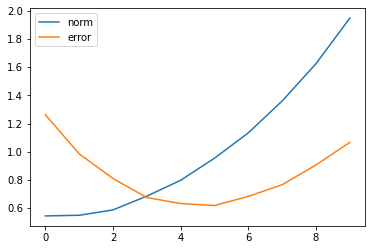

In [253]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_iter), norms, label="norm")
plt.plot(range(n_iter), errors, label="error")
plt.legend()

It seems like the if the matrix is diagonal-dominated, the approximate tends to be better

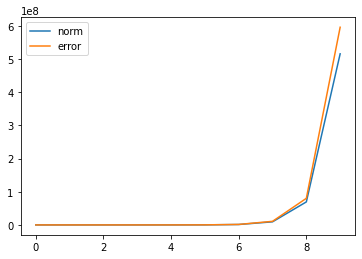

In [254]:
p = v = torch.eye(4)
norms_ = []
errors_ = []
for _ in range(n_iter):
    v = A @ v
    p = p + v
    norms_.append(torch.norm(v).item())
    errors_.append(torch.norm(exact_inv_A - p).item())

plt.plot(range(n_iter), norms_, label="norm")
plt.plot(range(n_iter), errors_, label="error")
plt.legend()

Traditional approach failed to converge. Obviously, this case does not statisfy assumption

#### Kronecker Factorization Approximation Curvature (KFAC)
As the method layer-wise factorize the Fisher matrix, at layer $\ell$, the Fisher matrix is

$$\mathbf{G}_{\ell\ell} = \mathbb{E}[\mathbf{a}_\ell \mathbf{a}_\ell^\top] \otimes \mathbb{E}[\cal{D}\mathbf{s}_\ell\cal{D}\mathbf{s}_\ell^\top]$$

where $\mathbf{s}_\ell$ is the output before activation of layer $\ell$, $\mathbf{a}_\ell$ is the activation output. $\cal{D}$ means derivative. 

There are several implementations in Pytorch floating around (e.g. [this](https://github.com/ajlangley/kfac-pytorch/blob/master/kfac/kfac.py) and [this](https://github.com/alecwangcq/KFAC-Pytorch/blob/master/optimizers/kfac.py)). 

The main trick is thatm at a layer, it attaches 2 hook functions at forward-pass phase and backward-pass phrase. The hook function at forward-pass phrase will record and aggregate the activation output $\mathbf{a}_\ell$. That of backward-pass phrase is responsible to collection information of $\cal{D}\mathbf{s}_\ell$

In fact, it will periodically use $\mathbf{G}_{\ell\ell}^{-1}$ to perform gradient descent update. There many other aspects including exponential moving average between minibatches and damping

In [23]:
m_aa = {} # store a_\ell a_\ell^\top
m_gg = {} # store Ds_ell Ds_\ell^\top

def save_input(module, input):
    a = input[0].data
    batch_size = a.shape[0]
    if module.bias is not None:
            a = torch.cat([a, a.new(a.size(0), 1).fill_(1)], 1)
    m_aa[module] = a.t() @ (a / batch_size)

def save_grad_output(module, grad_input, grad_output):
    g = grad_output[0].data
    batch_size = g.shape[0]
    m_gg[module] = g.t() @ (g / batch_size)

In [24]:
working_modules = []
for module in model.modules():
    classname = module.__class__.__name__
    if classname in ["Linear"]:
        working_modules.append(module)
        module.register_forward_pre_hook(save_input)
        module.register_backward_hook(save_grad_output)
        print("Hook %s" % (module))

Hook Linear(in_features=1, out_features=2, bias=True)
Hook Linear(in_features=2, out_features=1, bias=True)


In [27]:
logit = model(x)
loss = criterion(logit, y)
model.zero_grad()
loss.backward()

/home/anhth/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [28]:
d_a, Q_a = {},{} # store eigenvalues and eigenvectors w.r.t. aa^T
d_g, Q_g = {}, {} # store eigenvalues and eigenvectors w.r.t. gg^T
for m in working_modules:
    d_a[m], Q_a[m] = torch.symeig(m_aa[m], eigenvectors=True)
    d_g[m], Q_g[m] = torch.symeig(m_gg[m], eigenvectors=True)

In [29]:
kfac_inv_hvp = []
for m in working_modules:
    p_grad_mat = m.weight.grad.data
    p_grad_mat = torch.cat([p_grad_mat, m.bias.grad.data.view(-1,1)], dim=1)
    print(p_grad_mat)
    v1 = Q_g[m].t() @ p_grad_mat @ Q_a[m]
    v2 = v1 / (d_g[m].unsqueeze(1) * d_a[m].unsqueeze(0) + 0.1)
    v = Q_g[m] @ v2 @ Q_a[m].t()
    kfac_inv_hvp.append(v.view(-1,1))


tensor([[-0.0165,  0.2837],
        [-0.0048,  0.0877]])
tensor([[0.9421, 1.2221, 1.8950]])


In [31]:
torch.cat(kfac_inv_hvp, dim=0)

tensor([[-0.1636],
        [ 2.8108],
        [-0.0475],
        [ 0.8694],
        [ 5.8194],
        [ 7.5631],
        [11.7175]])

In [32]:
exact_inv_hvp

tensor([-2.0592e+00,  5.1093e-02, -1.1983e-01,  2.9922e-03, -6.1653e-03,
        -6.2554e-05,  9.5415e-01])